In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='face_full')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([522441, 608]),
 torch.Size([2494, 608]),
 torch.Size([522441]),
 torch.Size([2494]))

In [4]:
X_test = X_test[:1000]
y_test = y_test[:1000]

## DNN

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=608, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.720753  [    0/522441]
loss: 0.009907  [ 6400/522441]
loss: 0.012781  [12800/522441]
loss: 0.040487  [19200/522441]
loss: 0.069678  [25600/522441]
loss: 0.010902  [32000/522441]
loss: 0.000374  [38400/522441]
loss: 0.000330  [44800/522441]
loss: 0.044305  [51200/522441]
loss: 0.000077  [57600/522441]
loss: 0.000064  [64000/522441]
loss: 0.005542  [70400/522441]
loss: 0.001299  [76800/522441]
loss: 0.070262  [83200/522441]
loss: 0.000675  [89600/522441]
loss: 0.002949  [96000/522441]
loss: 0.000396  [102400/522441]
loss: 0.033271  [108800/522441]
loss: 0.005543  [115200/522441]
loss: 0.011297  [121600/522441]
loss: 0.001477  [128000/522441]
loss: 0.002731  [134400/522441]


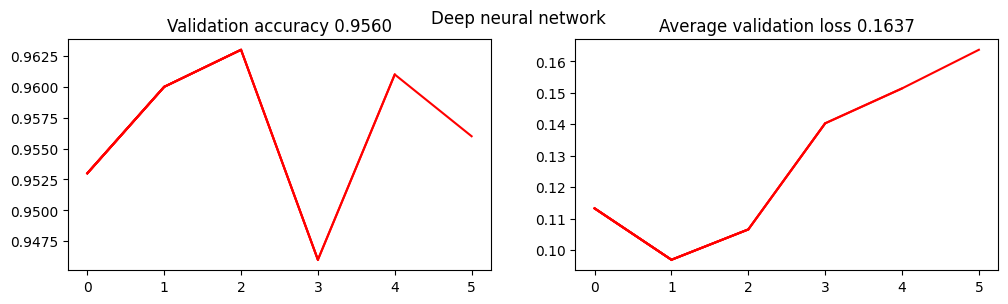

In [5]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomDataset(X_train, y_train, model_type='ffnn')
val_data = DNNmodels.CustomDataset(X_test, y_test, model_type='ffnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features).to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Deep neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    DNNmodels.train(train_dataloader, model_cnn, loss_fn, optimizer)
    DNNmodels.test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    DNNmodels.plot_results(axs, result)

In [6]:
torch.save(model_cnn.state_dict(), './model_dnn_facefull.pt')

In [7]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_facefull.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=608, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [9]:
with open('./onlinehd_facefull.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

In [10]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_dnn, X_train.reshape(len(X_train), features), X_test.reshape(len(X_test), features), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu',
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:00<00:00, 1019.56it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 1.0484346250013914 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 94.10%
mean of norm=0.00999999325722456


100%|██████████| 1000/1000 [00:00<00:00, 1272.60it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 0.7940408750000643 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 91.70%
mean of norm=0.02000000700354576


100%|██████████| 1000/1000 [00:00<00:00, 1261.23it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 0.8097070829971926 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 89.80%
mean of norm=0.030000001192092896


100%|██████████| 1000/1000 [00:00<00:00, 1252.22it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 0.8243289589991036 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 87.30%
mean of norm=0.04000001400709152


100%|██████████| 1000/1000 [00:00<00:00, 1220.01it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 0.8276895000017248 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 84.50%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:00<00:00, 1267.24it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 0.7991217079979833 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 81.80%
mean of norm=0.06000000238418579


100%|██████████| 1000/1000 [00:00<00:00, 1200.81it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 0.8452256669988856 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 78.40%
mean of norm=0.06999999284744263


100%|██████████| 1000/1000 [00:00<00:00, 1316.51it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 0.7709184579980501 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 75.60%
mean of norm=0.08000002801418304


100%|██████████| 1000/1000 [00:00<00:00, 1258.01it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 0.8032519170010346 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 72.90%
mean of norm=0.09000003337860107


100%|██████████| 1000/1000 [00:00<00:00, 1220.50it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 0.8300760839993018 seconds.
Accuracy: Before the attack -> 95.80%	|	After the attack -> 67.60%
mean of norm=0.10000003129243851


In [11]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.00999999325722456 0.9430000185966492 0.9409999847412109
0.020000000000000004 0.02000000700354576 0.9200000166893005 0.9169999957084656
0.030000000000000006 0.030000001192092896 0.9020000100135803 0.8980000019073486
0.04000000000000001 0.04000001400709152 0.8889999985694885 0.8730000257492065
0.05000000000000001 0.05000000447034836 0.8650000095367432 0.8450000286102295
0.06000000000000001 0.06000000238418579 0.8379999995231628 0.8180000185966492
0.07 0.06999999284744263 0.8159999847412109 0.7839999794960022
0.08 0.08000002801418304 0.7889999747276306 0.7559999823570251
0.09000000000000001 0.09000003337860107 0.7549999952316284 0.7289999723434448
0.1 0.10000003129243851 0.722000002861023 0.6759999990463257


### Deep Fool

In [12]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=max_update, num_classes=classes,
                                                               input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:24<00:00, 41.48it/s]


24.107789039611816
0.01 0.007964217104017735 0.9449999928474426 0.953000009059906


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


24.53368091583252
0.02 0.01592843420803547 0.9279999732971191 0.9319999814033508


100%|██████████| 1000/1000 [00:21<00:00, 46.40it/s]


21.554839849472046
0.03 0.02389265038073063 0.9229999780654907 0.9100000262260437


100%|██████████| 1000/1000 [00:20<00:00, 49.70it/s]


20.12162685394287
0.04 0.03185686469078064 0.8970000147819519 0.8799999952316284


100%|██████████| 1000/1000 [00:19<00:00, 51.44it/s]


19.440720796585083
0.05 0.039821092039346695 0.8629999756813049 0.8489999771118164


100%|██████████| 1000/1000 [00:18<00:00, 53.51it/s]


18.691009044647217
0.060000000000000005 0.047785308212041855 0.8389999866485596 0.8069999814033508


100%|██████████| 1000/1000 [00:17<00:00, 55.81it/s]


17.919463872909546
0.06999999999999999 0.055749520659446716 0.8059999942779541 0.7789999842643738


100%|██████████| 1000/1000 [00:16<00:00, 60.88it/s]


16.4288330078125
0.08 0.06371373683214188 0.7620000243186951 0.7049999833106995


100%|██████████| 1000/1000 [00:15<00:00, 63.90it/s]


15.652033805847168
0.09 0.07167796045541763 0.7160000205039978 0.6470000147819519


100%|██████████| 1000/1000 [00:14<00:00, 69.02it/s]


14.491245985031128
0.09999999999999999 0.07964218407869339 0.675000011920929 0.593999981880188


100%|██████████| 1000/1000 [00:13<00:00, 76.31it/s]


13.105918407440186
0.11 0.08760639280080795 0.6320000290870667 0.5320000052452087


100%|██████████| 1000/1000 [00:12<00:00, 82.46it/s]


12.129822015762329
0.12 0.09557060897350311 0.5789999961853027 0.48399999737739563


100%|██████████| 1000/1000 [00:11<00:00, 89.03it/s]


11.233901739120483
0.13 0.10353481769561768 0.5440000295639038 0.4399999976158142


100%|██████████| 1000/1000 [00:10<00:00, 96.16it/s]


10.400828123092651
0.14 0.11149904131889343 0.5 0.39500001072883606


100%|██████████| 1000/1000 [00:11<00:00, 88.24it/s]


11.335150718688965
0.15000000000000002 0.11946325749158859 0.46799999475479126 0.36399999260902405


100%|██████████| 1000/1000 [00:09<00:00, 108.99it/s]


9.178071022033691
0.16 0.12742745876312256 0.4309999942779541 0.33799999952316284


100%|██████████| 1000/1000 [00:08<00:00, 113.74it/s]


8.794771909713745
0.17 0.1353916972875595 0.39899998903274536 0.3149999976158142


100%|██████████| 1000/1000 [00:09<00:00, 102.86it/s]


9.724429845809937
0.18000000000000002 0.14335592091083527 0.3700000047683716 0.3019999861717224


100%|██████████| 1000/1000 [00:08<00:00, 121.18it/s]


8.254113912582397
0.19 0.15132015943527222 0.3449999988079071 0.289000004529953


100%|██████████| 1000/1000 [00:07<00:00, 125.21it/s]


7.988951206207275
0.2 0.15928436815738678 0.32499998807907104 0.2770000100135803


In [13]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, features), model_dnn, epsilon=None, num_classes=classes,
                                                           input_dim=features, model_type='dnn')
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:06<00:00, 144.36it/s]


6.929042816162109
None 0.17366960644721985 0.27399998903274536 0.23199999332427979


### Genetic Attack

In [14]:
alpha_lis = np.linspace(0.0004, 0.0037, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_dnn, delta, alpha, x_test_samp.reshape(-1, features), y_test_samp,
                                            input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0004


100%|██████████| 1000/1000 [31:43<00:00,  1.90s/it]


1903.737184047699
0.0004 0.011632203124463558 0.949999988079071 0.9459999799728394
Alpha : 0.0005736842105263159


100%|██████████| 1000/1000 [31:53<00:00,  1.91s/it]


1913.1782791614532
0.0005736842105263159 0.016547655686736107 0.9449999928474426 0.9390000104904175
Alpha : 0.0007473684210526316


100%|██████████| 1000/1000 [32:35<00:00,  1.96s/it]


1955.5348899364471
0.0007473684210526316 0.02141932025551796 0.9369999766349792 0.9350000023841858
Alpha : 0.0009210526315789475


100%|██████████| 1000/1000 [30:29<00:00,  1.83s/it]


1829.9671800136566
0.0009210526315789475 0.026083694770932198 0.9340000152587891 0.9269999861717224
Alpha : 0.0010947368421052631


100%|██████████| 1000/1000 [30:29<00:00,  1.83s/it]


1829.1517860889435
0.0010947368421052631 0.030717972666025162 0.9300000071525574 0.9229999780654907
Alpha : 0.001268421052631579


100%|██████████| 1000/1000 [30:13<00:00,  1.81s/it]


1813.9617710113525
0.001268421052631579 0.035101842135190964 0.9330000281333923 0.9169999957084656
Alpha : 0.0014421052631578947


100%|██████████| 1000/1000 [30:50<00:00,  1.85s/it]


1850.2760009765625
0.0014421052631578947 0.03917888179421425 0.9300000071525574 0.9169999957084656
Alpha : 0.0016157894736842104


100%|██████████| 1000/1000 [35:01<00:00,  2.10s/it]


2101.8857979774475
0.0016157894736842104 0.04307330399751663 0.9259999990463257 0.9169999957084656
Alpha : 0.0017894736842105263


100%|██████████| 1000/1000 [34:26<00:00,  2.07s/it]


2066.3650040626526
0.0017894736842105263 0.04627171531319618 0.925000011920929 0.9150000214576721
Alpha : 0.0019631578947368424


100%|██████████| 1000/1000 [35:16<00:00,  2.12s/it]


2116.5383768081665
0.0019631578947368424 0.04931102320551872 0.9269999861717224 0.9169999957084656
Alpha : 0.002136842105263158


100%|██████████| 1000/1000 [31:24<00:00,  1.88s/it]


1884.8965730667114
0.002136842105263158 0.05198962613940239 0.9200000166893005 0.9179999828338623
Alpha : 0.002310526315789474


100%|██████████| 1000/1000 [30:11<00:00,  1.81s/it]


1812.0130848884583
0.002310526315789474 0.05429539829492569 0.9269999861717224 0.9179999828338623
Alpha : 0.0024842105263157897


100%|██████████| 1000/1000 [30:09<00:00,  1.81s/it]


1809.238911151886
0.0024842105263157897 0.05565889924764633 0.925000011920929 0.9259999990463257
Alpha : 0.0026578947368421056


100%|██████████| 1000/1000 [30:09<00:00,  1.81s/it]


1809.0915520191193
0.0026578947368421056 0.0575530044734478 0.921999990940094 0.9200000166893005
Alpha : 0.002831578947368421


100%|██████████| 1000/1000 [30:11<00:00,  1.81s/it]


1811.463739156723
0.002831578947368421 0.05863063037395477 0.9269999861717224 0.925000011920929
Alpha : 0.003005263157894737


100%|██████████| 1000/1000 [30:11<00:00,  1.81s/it]


1811.0872972011566
0.003005263157894737 0.059649161994457245 0.9200000166893005 0.9269999861717224
Alpha : 0.003178947368421053


100%|██████████| 1000/1000 [30:19<00:00,  1.82s/it]


1819.6956312656403
0.003178947368421053 0.06170472502708435 0.9200000166893005 0.9290000200271606
Alpha : 0.003352631578947369


100%|██████████| 1000/1000 [30:05<00:00,  1.81s/it]


1805.1859469413757
0.003352631578947369 0.062258705496788025 0.9259999990463257 0.9240000247955322
Alpha : 0.0035263157894736847


100%|██████████| 1000/1000 [30:12<00:00,  1.81s/it]


1812.2730729579926
0.0035263157894736847 0.0634581595659256 0.925000011920929 0.9330000281333923
Alpha : 0.0037


100%|██████████| 1000/1000 [30:05<00:00,  1.81s/it]


1805.9476110935211
0.0037 0.0641712173819542 0.9240000247955322 0.9229999780654907
